In [65]:
import geopandas as gpd
import pandas as pd
import requests as req
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np


# Path to the .tab file inside the zip
tab_file = "rakennukset_Helsinki_06_2012_wgs84.TAB"

# Read the .tab file using geopandas
df = gpd.read_file(tab_file)

In [66]:
# Select the columns you want first
df = df[["Osoite", "C_VALMPVM", "C_JULKISIVU", "I_PYRAKNRO", "I_KERROSALA", "I_KERRLKM", "C_LAMMTAPA", "C_POLTAINE", "I_RAKTILAV", "C_RAKEAINE", "I_HUONLKM", "C_ENERGIALUOKKA"]]

df.sort_values(by="C_VALMPVM", ascending=False, inplace=True)
df.drop_duplicates(subset=["Osoite"], inplace=True)

# Top 2 rows had 2050 as year built so we drop them
df = df[2:]

# Convert to numeric
df["Year_built"] = pd.to_numeric(df["C_VALMPVM"].str[:4], errors='coerce')
df["I_KERROSALA"] = pd.to_numeric(df["I_KERROSALA"], errors='coerce')
df["I_KERRLKM"] = pd.to_numeric(df["I_KERRLKM"], errors='coerce')
df["I_RAKTILAV"] = pd.to_numeric(df["I_RAKTILAV"], errors='coerce')
df["I_HUONLKM"] = pd.to_numeric(df["I_HUONLKM"], errors='coerce')
df["C_LAMMTAPA"] = pd.to_numeric(df["C_LAMMTAPA"], errors='coerce')
df["C_POLTAINE"] = pd.to_numeric(df["C_POLTAINE"], errors='coerce')
df["C_ENERGIALUOKKA"] = pd.to_numeric(df["C_ENERGIALUOKKA"], errors='coerce')

# Rename columns
df = df.rename(columns={
    "Osoite": "Address",
    "C_VALMPVM": "Date_Built",
    "C_JULKISIVU": "Facade_Material",
    "I_PYRAKNRO": "Building_ID",
    "I_KERROSALA": "Floor_Area_m2",
    "I_HUONLKM": "Number_of_Rooms",
    "I_KERRLKM": "Number_of_Floors",
    "C_LAMMTAPA": "Heating_Method",
    "C_POLTAINE": "Fuel_Type",
    "I_RAKTILAV": "Building_Volume_m3",
    "C_RAKEAINE": "Building_Material",
    "C_ENERGIALUOKKA": "Energy_Class"
})

# Clean data: keep only rows with all required features
feature_columns = ["Year_built", "Floor_Area_m2", "Number_of_Rooms", "Number_of_Floors", 
                   "Building_Volume_m3", "Heating_Method", "Fuel_Type", 
                   "Building_Material", "Facade_Material", "Energy_Class"]

# Drop rows with any missing values in the feature columns
df_clean = df.dropna(subset=feature_columns)

print(f"Original dataset: {len(df)} rows")
print(f"Clean dataset: {len(df_clean)} rows")
print(f"Removed {len(df) - len(df_clean)} rows with missing data")

df = df_clean

Original dataset: 28803 rows
Clean dataset: 536 rows
Removed 28267 rows with missing data


In [67]:
from sklearn.preprocessing import StandardScaler
# Add this import at the top with other imports

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Select features
X_train = train_df[["Year_built", "Floor_Area_m2", "Building_Volume_m3", "Heating_Method", "Building_Material", "Facade_Material"]]
y_train = train_df["Energy_Class"]

X_test = test_df[["Year_built", "Floor_Area_m2", "Building_Volume_m3", "Heating_Method", "Building_Material", "Facade_Material"]]
y_test = test_df["Energy_Class"]

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model on scaled data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.4074074074074074


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (7).

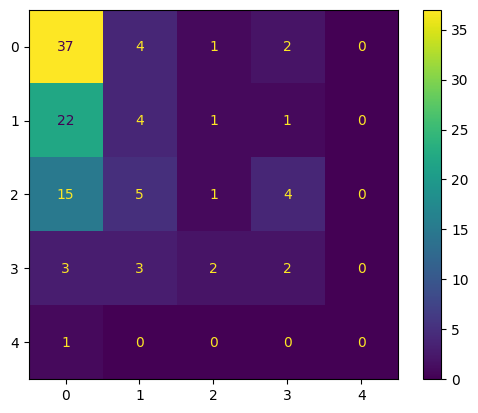

In [68]:
# Get the actual unique values from your data
unique_classes = sorted(df['Energy_Class'].unique())
conf_mat = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=unique_classes)

cm_display.plot()
plt.title("Energy Class Prediction Confusion Matrix")
plt.show()